In [404]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SQL_queries as q

# Exploratory Data Analysis - Pittsburgh Penguins Playoff Data From 2016 and 2017
--------
### To begin the EDA process, I use SQL queries to build DataFrames to include:

* general information about each game, play, event, and event locations
* skater stats
* team stats
* shift information
### [Check out the queries for yourself](SQL_queries.py)
----



In [223]:
conn = sqlite3.connect('NHL_data.db')

In [224]:
pens_2016_playoff_df = pd.read_sql_query(q.playoff_2016_data_query, conn)
pens_2016_playoff_df.head()

,Unnamed: 0,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,...,periodTimeRemaining,dateTime,goals_away,goals_home,play_id,game_id,player_id,playerType,firstName,lastName
0,3165356,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,...,1200.0,2016-04-14 01:10:15,0,0,2015030141_4,2015030141,8471675,Winner,Sidney,Crosby
1,3165356,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,...,1200.0,2016-04-14 01:10:15,0,0,2015030141_4,2015030141,8474613,Loser,Derek,Stepan
2,3165358,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,...,1193.0,2016-04-14 01:10:52,0,0,2015030141_6,2015030141,8471675,Loser,Sidney,Crosby
3,3165358,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,...,1193.0,2016-04-14 01:10:52,0,0,2015030141_6,2015030141,8474613,Winner,Derek,Stepan
4,3165359,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,...,1185.0,2016-04-14 01:11:17,0,0,2015030141_7,2015030141,8470630,Hitter,Kevin,Klein


In [225]:
pens_2017_playoff_df = pd.read_sql_query(q.playoff_2017_data_query, conn)
pens_2017_playoff_df.head()

,Unnamed: 0,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,...,periodTimeRemaining,dateTime,goals_away,goals_home,play_id,game_id,player_id,playerType,firstName,lastName
0,3211410,2016030141_4,2016030141,29.0,5.0,Faceoff,None,0.0,0.0,1,...,1200.0,2017-04-13 00:40:08,0,0,2016030141_4,2016030141,8471273,Winner,Brandon,Dubinsky
1,3211410,2016030141_4,2016030141,29.0,5.0,Faceoff,None,0.0,0.0,1,...,1200.0,2017-04-13 00:40:08,0,0,2016030141_4,2016030141,8471675,Loser,Sidney,Crosby
2,3211411,2016030141_5,2016030141,29.0,5.0,Hit,None,3.0,39.0,1,...,1182.0,2017-04-13 00:40:40,0,0,2016030141_5,2016030141,8476432,Hitter,Boone,Jenner
3,3211411,2016030141_5,2016030141,29.0,5.0,Hit,None,3.0,39.0,1,...,1182.0,2017-04-13 00:40:40,0,0,2016030141_5,2016030141,8477404,Hittee,Jake,Guentzel
4,3211412,2016030141_6,2016030141,29.0,5.0,Hit,None,-91.0,-36.0,1,...,1178.0,2017-04-13 00:40:44,0,0,2016030141_6,2016030141,8471273,Hitter,Brandon,Dubinsky


### The query was quick and easy, but seems to have given some repetitive data. To confirm, I checked the columns:

In [226]:
pens_2016_playoff_df.columns

Index(['Unnamed: 0', 'play_id', 'game_id', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'play_id', 'game_id', 'player_id', 'playerType',
       'firstName', 'lastName'],
      dtype='object')

### As expected, some columns are the same.
Below I drop any duplicated columns, as well as any additional columns that are unnecessary at this time.

In [227]:
playoff_dfs = [pens_2016_playoff_df, pens_2017_playoff_df]

In [228]:
fixed_playoff_dfs = []
for df in playoff_dfs:
    df = df.iloc[:,~df.columns.duplicated()]
    df = df.drop(['Unnamed: 0','player_id'], axis=1)
    fixed_playoff_dfs.append(df)


In [229]:
fixed_playoff_dfs

[              play_id     game_id  team_id_for  team_id_against         event  \
 0        2015030141_4  2015030141          5.0              3.0       Faceoff   
 1        2015030141_4  2015030141          5.0              3.0       Faceoff   
 2        2015030141_6  2015030141          3.0              5.0       Faceoff   
 3        2015030141_6  2015030141          3.0              5.0       Faceoff   
 4        2015030141_7  2015030141          3.0              5.0           Hit   
 ...               ...         ...          ...              ...           ...   
 13174  2015030416_369  2015030416          5.0             28.0       Penalty   
 13175  2015030416_370  2015030416          5.0             28.0       Faceoff   
 13176  2015030416_370  2015030416          5.0             28.0       Faceoff   
 13177  2015030416_371  2015030416          5.0             28.0  Blocked Shot   
 13178  2015030416_371  2015030416          5.0             28.0  Blocked Shot   
 
       seconda

In [230]:
pens_2016_playoff_df = fixed_playoff_dfs[0]
pens_2017_playoff_df = fixed_playoff_dfs[1]

check to verify changes:

In [235]:
pens_2016_playoff_df.columns

Index(['play_id', 'game_id', 'team_id_for', 'team_id_against', 'event',
       'secondaryType', 'x', 'y', 'period', 'periodType', 'periodTime',
       'periodTimeRemaining', 'dateTime', 'goals_away', 'goals_home',
       'playerType', 'firstName', 'lastName'],
      dtype='object')

### To explore, let's take a closer look at event, secondaryType, and periodType:

In [32]:
pens_2016_playoff_df.event.unique()

array(['Faceoff', 'Hit', 'Blocked Shot', 'Shot', 'Missed Shot',
       'Giveaway', 'Penalty', 'Takeaway', 'Goal'], dtype=object)

In [33]:
pens_2016_playoff_df.secondaryType.unique()

array([None, 'Snap Shot', 'Wrist Shot', 'Slap Shot', 'Wrap-around',
       'Hooking', 'Tip-In', 'Illegal check to head',
       'Unsportsmanlike conduct', 'Interference', 'Backhand', 'Holding',
       'Tripping', 'Hi stick - double minor', 'Roughing',
       'Interference - Goalkeeper', 'Slashing', 'Cross checking',
       'Fighting', 'Boarding', 'Holding the stick', 'Hi-sticking',
       'Embellishment', 'Too many men on the ice',
       'Delaying Game - Puck over glass', 'Elbowing', 'Misconduct',
       'Deflected'], dtype=object)

In [34]:
pens_2016_playoff_df.periodType.unique()

array(['REGULAR', 'OVERTIME'], dtype=object)

### Next, check for null values in both DataFrames:

In [35]:
pens_2016_playoff_df.info()
pens_2017_playoff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13179 entries, 0 to 13178
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   play_id              13179 non-null  object 
 1   game_id              13179 non-null  int64  
 2   team_id_for          13179 non-null  float64
 3   team_id_against      13179 non-null  float64
 4   event                13179 non-null  object 
 5   secondaryType        3586 non-null   object 
 6   x                    13163 non-null  float64
 7   y                    13165 non-null  float64
 8   period               13179 non-null  int64  
 9   periodType           13179 non-null  object 
 10  periodTime           13179 non-null  int64  
 11  periodTimeRemaining  13179 non-null  float64
 12  dateTime             13179 non-null  object 
 13  goals_away           13179 non-null  int64  
 14  goals_home           13179 non-null  int64  
 15  playerType           13179 non-null 

Secondary type is the only column that contains null values. What percent are null? Is this column worth keeping?

In [36]:
secondary_type_percent_null_1 = (pens_2016_playoff_df['secondaryType'].isnull().sum())/13179*100
secondary_type_percent_null_2 = (pens_2017_playoff_df['secondaryType'].isnull().sum())/11559*100

print(f'2016 Secondary Type Null Percent :{secondary_type_percent_null_1:.2f}%')
print(f'2017 Secondary Type Null Percent :{secondary_type_percent_null_2:.2f}%')


2016 Secondary Type Null Percent :72.79%
2017 Secondary Type Null Percent :71.62%


Looking in on what events have secondary types:

In [37]:
pens_2016_playoff_df[pens_2016_playoff_df['event']=='Penalty']

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
64,2015030141_45,2015030141,3.0,5.0,Penalty,Hooking,-69.0,-37.0,1,REGULAR,319,881.0,2016-04-14 01:19:52,0,0,PenaltyOn,Viktor,Stalberg
65,2015030141_45,2015030141,3.0,5.0,Penalty,Hooking,-69.0,-37.0,1,REGULAR,319,881.0,2016-04-14 01:19:52,0,0,DrewBy,Justin,Schultz
113,2015030141_75,2015030141,3.0,5.0,Penalty,Illegal check to head,-97.0,28.0,1,REGULAR,647,553.0,2016-04-14 01:33:50,0,0,PenaltyOn,Viktor,Stalberg
114,2015030141_75,2015030141,3.0,5.0,Penalty,Illegal check to head,-97.0,28.0,1,REGULAR,647,553.0,2016-04-14 01:33:50,0,0,DrewBy,Ian,Cole
125,2015030141_84,2015030141,5.0,3.0,Penalty,Unsportsmanlike conduct,NaN,NaN,1,REGULAR,779,421.0,2016-04-14 01:37:32,0,0,DrewBy,Henrik,Lundqvist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13080,2015030416_303,2015030416,5.0,28.0,Penalty,Hooking,-29.0,-33.0,3,REGULAR,326,874.0,2016-06-13 03:18:14,2,1,PenaltyOn,Conor,Sheary
13118,2015030416_329,2015030416,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2016-06-13 03:25:48,2,1,PenaltyOn,Brent,Burns
13119,2015030416_329,2015030416,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2016-06-13 03:25:48,2,1,DrewBy,Phil,Kessel
13173,2015030416_369,2015030416,5.0,28.0,Penalty,Hi-sticking,32.0,4.0,3,REGULAR,1190,10.0,2016-06-13 03:46:00,3,1,PenaltyOn,Eric,Fehr


In [38]:
pens_2016_playoff_df[pens_2016_playoff_df['event']=='Shot']

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
12,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,2016-04-14 01:12:47,0,0,Goalie,Henrik,Lundqvist
13,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,2016-04-14 01:12:47,0,0,Shooter,Phil,Kessel
25,2015030141_20,2015030141,3.0,5.0,Shot,Wrist Shot,-63.0,-6.0,1,REGULAR,165,1035.0,2016-04-14 01:14:16,0,0,Goalie,Jeff,Zatkoff
26,2015030141_20,2015030141,3.0,5.0,Shot,Wrist Shot,-63.0,-6.0,1,REGULAR,165,1035.0,2016-04-14 01:14:16,0,0,Shooter,J.T.,Miller
33,2015030141_24,2015030141,3.0,5.0,Shot,Slap Shot,-47.0,35.0,1,REGULAR,213,987.0,2016-04-14 01:15:10,0,0,Shooter,Kevin,Klein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13132,2015030416_339,2015030416,5.0,28.0,Shot,Slap Shot,-81.0,-5.0,3,REGULAR,858,342.0,2016-06-13 03:34:03,2,1,Goalie,Martin,Jones
13142,2015030416_346,2015030416,5.0,28.0,Shot,Wrist Shot,-76.0,17.0,3,REGULAR,957,243.0,2016-06-13 03:35:44,2,1,Shooter,Carl,Hagelin
13143,2015030416_346,2015030416,5.0,28.0,Shot,Wrist Shot,-76.0,17.0,3,REGULAR,957,243.0,2016-06-13 03:35:44,2,1,Goalie,Martin,Jones
13164,2015030416_363,2015030416,28.0,5.0,Shot,Wrist Shot,57.0,-25.0,3,REGULAR,1154,46.0,2016-06-13 03:43:58,3,1,Shooter,Joonas,Donskoi


### After seeing that 72% & 73% of secondaryType rows are NULL, I've decided to drop the columns. 
When it comes to penalties, for this project I'll be looking at the penalty differentials, for which these types listed won't matter. Additionally, I'll be making a DataFrame specifically for shots, in which I can use the secondary type for this event. For now, event will suffice.

In [236]:
pens_2016_playoff_df = pens_2016_playoff_df.drop('secondaryType',axis=1)
pens_2017_playoff_df = pens_2017_playoff_df.drop('secondaryType', axis=1)

### Next step : Make things easier to discern.
To replace the columns team_id_for and team_id_against with abbreviations instead of numbers, I first pulled the data using a SQL query from the database, created a DataFrame, and then transformed it to a dictionary. Using this dictionary, the team_id numbers are replaced with easily identifiable team info.

In [237]:
team_ids_df = pd.read_sql_query(q.get_abb_query, conn)
abb_dict = pd.Series(team_ids_df.abbreviation.values,index=team_ids_df.team_id).to_dict()
abb_dict

{1: 'NJD',
 4: 'PHI',
 26: 'LAK',
 14: 'TBL',
 6: 'BOS',
 3: 'NYR',
 5: 'PIT',
 17: 'DET',
 28: 'SJS',
 18: 'NSH',
 23: 'VAN',
 16: 'CHI',
 9: 'OTT',
 8: 'MTL',
 30: 'MIN',
 15: 'WSH',
 19: 'STL',
 24: 'ANA',
 27: 'PHX',
 2: 'NYI',
 10: 'TOR',
 13: 'FLA',
 7: 'BUF',
 20: 'CGY',
 21: 'COL',
 25: 'DAL',
 29: 'CBJ',
 52: 'WPG',
 22: 'EDM',
 54: 'VGK',
 12: 'CAR',
 53: 'ARI',
 11: 'ATL'}

In [238]:
#reset the df lists once more
dfs = fixed_playoff_dfs
fixed_playoff_dfs = []
#replace and rename for each
for df in dfs:
    df = df.replace({'team_id_for':abb_dict})
    df = df.replace({'team_id_against':abb_dict})
    df = df.rename(columns={'team_id_for':'team_for', 'team_id_against':'team_against'})
    fixed_playoff_dfs.append(df)
#reassign to original df names
pens_2016_playoff_df = fixed_playoff_dfs[0]
pens_2017_playoff_df = fixed_playoff_dfs[1]

In [239]:
pens_2016_playoff_df.head()

,play_id,game_id,team_for,team_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
0,2015030141_4,2015030141,PIT,NYR,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Winner,Sidney,Crosby
1,2015030141_4,2015030141,PIT,NYR,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Loser,Derek,Stepan
2,2015030141_6,2015030141,NYR,PIT,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Loser,Sidney,Crosby
3,2015030141_6,2015030141,NYR,PIT,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Winner,Derek,Stepan
4,2015030141_7,2015030141,NYR,PIT,Hit,None,-5.0,-40.0,1,REGULAR,15,1185.0,2016-04-14 01:11:17,0,0,Hitter,Kevin,Klein


### Take a closer look at game_id
I'll want to do game by game analysis for players. I need to be able to:
* group by game_id
* groupy by opposing team (the team playing against the Pittsburgh Penguins)
* consider how many games are played for each playoff round

In [240]:
games_teams_2016 = pens_2016_playoff_df.groupby('game_id').team_for.unique().reset_index()
games_teams_2017 = pens_2017_playoff_df.groupby('game_id').team_for.unique().reset_index()

In [241]:
games_teams_2017

,game_id,team_for
0,2016030141,"[CBJ, PIT]"
1,2016030142,"[CBJ, PIT]"
2,2016030143,"[PIT, CBJ]"
3,2016030144,"[PIT, CBJ]"
4,2016030145,"[PIT, CBJ]"
5,2016030221,"[PIT, WSH]"
6,2016030222,"[WSH, PIT]"
7,2016030223,"[PIT, WSH]"
8,2016030224,"[WSH, PIT]"
9,2016030226,"[PIT, WSH]"


This is helpful, but it shows both teams, where I only need the opposing team. 

In [242]:
games_teams_2016['opposing_team'] = games_teams_2016['team_for'].apply(
    lambda row: [val for val in row if val != 'PIT']
)
games_teams_2016.drop('team_for',axis=1, inplace=True)
games_teams_2016

,game_id,opposing_team
0,2015030141,[NYR]
1,2015030142,[NYR]
2,2015030143,[NYR]
3,2015030144,[NYR]
4,2015030145,[NYR]
5,2015030221,[WSH]
6,2015030222,[WSH]
7,2015030223,[WSH]
8,2015030224,[WSH]
9,2015030225,[WSH]


In [243]:
games_teams_2017['opposing_team'] = games_teams_2017['team_for'].apply(
   
    lambda row: [val for val in row if val != 'PIT']
)
games_teams_2017.drop('team_for',axis=1, inplace=True)

In [244]:
games_teams_2017

,game_id,opposing_team
0,2016030141,[CBJ]
1,2016030142,[CBJ]
2,2016030143,[CBJ]
3,2016030144,[CBJ]
4,2016030145,[CBJ]
5,2016030221,[WSH]
6,2016030222,[WSH]
7,2016030223,[WSH]
8,2016030224,[WSH]
9,2016030226,[WSH]


In [245]:
games_teams_2016.opposing_team.value_counts()

opposing_team
[TBL]    7
[WSH]    6
[SJS]    6
[NYR]    5
Name: count, dtype: int64

In [246]:
games_teams_2017.opposing_team.value_counts()

opposing_team
[WSH]    6
[OTT]    6
[CBJ]    5
[NSH]    5
Name: count, dtype: int64

Looking above, we can see how many games are played against each opposing team, for both years.

Next, I need lists of game_ids for each round of both playoff years.

In [247]:
#isolate the team name, since it has become a list instead of a string:
games_teams_2016['opposing_team'] = games_teams_2016['opposing_team'].str[0]

In [248]:
games_teams_2016

,game_id,opposing_team
0,2015030141,NYR
1,2015030142,NYR
2,2015030143,NYR
3,2015030144,NYR
4,2015030145,NYR
5,2015030221,WSH
6,2015030222,WSH
7,2015030223,WSH
8,2015030224,WSH
9,2015030225,WSH


In [249]:
#works well! do for 2017 also
games_teams_2017['opposing_team'] = games_teams_2017['opposing_team'].str[0]

In [250]:
games_teams_2016.groupby('opposing_team').game_id.unique()

opposing_team
NYR    [2015030141, 2015030142, 2015030143, 201503014...
SJS    [2015030411, 2015030412, 2015030413, 201503041...
TBL    [2015030311, 2015030312, 2015030313, 201503031...
WSH    [2015030221, 2015030222, 2015030223, 201503022...
Name: game_id, dtype: object

In [251]:
games_teams_2017.groupby('opposing_team').game_id.unique()

opposing_team
CBJ    [2016030141, 2016030142, 2016030143, 201603014...
NSH    [2016030411, 2016030412, 2016030413, 201603041...
OTT    [2016030311, 2016030312, 2016030314, 201603031...
WSH    [2016030221, 2016030222, 2016030223, 201603022...
Name: game_id, dtype: object

I want a list of only game_ids for each opposing team round:

In [253]:
#2016:
NYR_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='NYR'].game_id)
SJS_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='SJS'].game_id)
TBL_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='TBL'].game_id)
WSH_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='WSH'].game_id)
#2017:
CBJ_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='CBJ'].game_id)
NSH_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='NSH'].game_id)
OTT_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='OTT'].game_id)
WSH_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='WSH'].game_id)

### Next, I can choose to isolate information from the original large DataFrame, based on the game_id numbers

These were the round match-ups:

--------------


| Year   | 2016                  | 2017 |
|--------|-----------------------|-----|
| Round 1 | New York Rangers      | Columbus Blue Jackets |
| Round 2 | Washington Capitals   | Washington Capitals |
| Round 3 | Tampa Bay Lightning   | Ottowa Senators |
| Final | San Jose Sharks       | Nashville Predators |


In [316]:
#Breaking the data into separate rounds of the playoffs

#2016:
Round_1_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(NYR_2016_games)]
Round_2_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(WSH_2016_games)]
Round_3_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(TBL_2016_games)]
Round_4_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(SJS_2016_games)]

#2017:
Round_1_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(CBJ_2017_games)]
Round_2_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(WSH_2017_games)]
Round_3_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(OTT_2017_games)]
Round_4_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(NSH_2017_games)]


Take another look at what we have for this first DataFrame:

In [317]:
Round_1_2016

,play_id,game_id,team_for,team_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
0,2015030141_4,2015030141,PIT,NYR,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Winner,Sidney,Crosby
1,2015030141_4,2015030141,PIT,NYR,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Loser,Derek,Stepan
2,2015030141_6,2015030141,NYR,PIT,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Loser,Sidney,Crosby
3,2015030141_6,2015030141,NYR,PIT,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Winner,Derek,Stepan
4,2015030141_7,2015030141,NYR,PIT,Hit,None,-5.0,-40.0,1,REGULAR,15,1185.0,2016-04-14 01:11:17,0,0,Hitter,Kevin,Klein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,2015030145_370,2015030145,PIT,NYR,Blocked Shot,None,-43.0,2.0,3,REGULAR,1103,97.0,2016-04-23 22:54:11,3,6,Shooter,Brady,Skjei
2744,2015030145_371,2015030145,PIT,NYR,Blocked Shot,None,-72.0,-5.0,3,REGULAR,1162,38.0,2016-04-23 22:55:10,3,6,Blocker,Patric,Hornqvist
2745,2015030145_371,2015030145,PIT,NYR,Blocked Shot,None,-72.0,-5.0,3,REGULAR,1162,38.0,2016-04-23 22:55:10,3,6,Shooter,Ryan,McDonagh
2746,2015030145_372,2015030145,PIT,NYR,Blocked Shot,None,-50.0,12.0,3,REGULAR,1174,26.0,2016-04-23 22:55:22,3,6,Shooter,Kevin,Klein


When thinking about positive or negative plays, do we even need to see the event, or can we infer based on playertype? 

In [318]:
events = Round_1_2016['event'].unique()
for event in events:
    print(f'{event} Player Type Options:',end='')
    print(Round_1_2016[Round_1_2016['event']==event].playerType.unique())

Faceoff Player Type Options:['Winner' 'Loser']
Hit Player Type Options:['Hitter' 'Hittee']
Blocked Shot Player Type Options:['Shooter' 'Blocker']
Shot Player Type Options:['Goalie' 'Shooter']
Missed Shot Player Type Options:['Shooter']
Giveaway Player Type Options:['PlayerID']
Penalty Player Type Options:['PenaltyOn' 'DrewBy' 'ServedBy']
Takeaway Player Type Options:['PlayerID']
Goal Player Type Options:['Goalie' 'Assist' 'Scorer']


As I hoped, for most everything other than giveaway and takeaway, the player type is enough information to determine good/bad plays.

In [323]:
Round_1_2016

,play_id,game_id,team_for,team_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
0,2015030141_4,2015030141,PIT,NYR,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Winner,Sidney,Crosby
1,2015030141_4,2015030141,PIT,NYR,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Loser,Derek,Stepan
2,2015030141_6,2015030141,NYR,PIT,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Loser,Sidney,Crosby
3,2015030141_6,2015030141,NYR,PIT,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Winner,Derek,Stepan
4,2015030141_7,2015030141,NYR,PIT,Hit,None,-5.0,-40.0,1,REGULAR,15,1185.0,2016-04-14 01:11:17,0,0,Hitter,Kevin,Klein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,2015030145_370,2015030145,PIT,NYR,Blocked Shot,None,-43.0,2.0,3,REGULAR,1103,97.0,2016-04-23 22:54:11,3,6,Shooter,Brady,Skjei
2744,2015030145_371,2015030145,PIT,NYR,Blocked Shot,None,-72.0,-5.0,3,REGULAR,1162,38.0,2016-04-23 22:55:10,3,6,Blocker,Patric,Hornqvist
2745,2015030145_371,2015030145,PIT,NYR,Blocked Shot,None,-72.0,-5.0,3,REGULAR,1162,38.0,2016-04-23 22:55:10,3,6,Shooter,Ryan,McDonagh
2746,2015030145_372,2015030145,PIT,NYR,Blocked Shot,None,-50.0,12.0,3,REGULAR,1174,26.0,2016-04-23 22:55:22,3,6,Shooter,Kevin,Klein


In [324]:
Round_1_2016.groupby('lastName').playerType.value_counts()

lastName    playerType
Bonino      Winner        43
            Loser         39
            Hittee         9
            Blocker        6
            Shooter        6
                          ..
Zuccarello  Loser          1
            PlayerID       1
            Scorer         1
            Assist         1
            Winner         1
Name: count, Length: 348, dtype: int64

plotting project below in progress, please disregard until complete.

In [343]:
# def plotHockeyPoints(data, column, column_filter):
#     scatter_data = data.loc[data[column]==column_filter]
#     xpoints = np.array(scatter_data['x'])
#     ypoints = np.array(scatter_data['y'])
#     plt.figure(figsize=(10,8))
#     fig = sns.scatterplot(x=xpoints, y=ypoints, data= scatter_data, hue='team_for')
#     plt.title(f'Location of {column_filter}s')
#     im = plt.imread("rink.jpg")
#     im = fig.imshow(im, extent=[-105, 105, -45.5, 45.5])
#     plt.xlabel=None
#     plt.ylabel=None
#     fig.set(xticklabels=[])
#     fig.set(yticklabels=[])
#     fig.grid(False)
#     plt.show()
#     plt.close()


In [327]:
# def sort_good_bad_plays(df):
#     good_plays_df = df[df['playerType'].isin(['Hitter','Blocker','Scorer','Shooter'])]
#     bad_plays_df = df[df['playerType'].isin(['Hittee','Shooter','DrewBy'])]
#     return good_plays_df, bad_plays_df
    

In [328]:
# Round_1_2016_good_plays, Round_1_2016_bad_plays = sort_good_bad_plays(Round_1_2016)

In [333]:
# good_player_types = Round_1_2016_good_plays.playerType.unique()

In [334]:
# bad_player_types = Round_1_2016_bad_plays.playerType.unique()

In [211]:
# player_types = ['Hitter','Scorer','Blocker']

Plot play locations for good and bad plays, Round 1, 2016 Playoffs:

In [346]:
# for type in good_player_types:
#     plotHockeyPoints(Round_1_2016_good_plays, 'playerType', type)

In [347]:
# for type in bad_player_types:
#     plotHockeyPoints(Round_1_2016_bad_plays, 'playerType', type)

### Next, begin gathering more skater stats:

The next SQL query will pull in player stats already compiled per game per player.

In [405]:
pens_2016_playoff_skater_stats_df = pd.read_sql_query(q.skater_stats_query,conn)

In [406]:
pens_2016_playoff_skater_stats_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,abbreviation
0,2015030141,8464989,5,952,0,0,0,2.0,0,0,...,0,0,1.0,-1,757,195,0,Matt,Cullen,PIT
1,2015030141,8467096,3,1194,1,0,1,0.0,0,0,...,0,0,1.0,0,961,0,233,Dan,Boyle,NYR
2,2015030141,8468575,3,640,0,0,0,0.0,0,0,...,0,0,0.0,0,534,99,7,Dominic,Moore,NYR
3,2015030141,8470041,3,1114,1,0,1,2.0,0,1,...,0,0,1.0,-2,679,256,179,Rick,Nash,NYR
4,2015030141,8470110,5,1480,1,0,4,0.0,0,0,...,0,0,1.0,1,1038,45,397,Trevor,Daley,PIT


As we've already added names and team abbreviations, we can drop a couple of columns:

In [353]:
pens_2016_playoff_skater_stats_df = pens_2016_playoff_skater_stats_df.drop(['player_id','team_id'], axis=1)

### Before separating into individual games and playoff rounds, it's helpful to take a look at the playoffs as a whole for the Pittsburgh Penguins:

In [354]:
players_2016_sums_df = pens_2016_playoff_skater_stats_df.groupby('lastName').aggregate({'goals':'sum', 'assists':'sum', 'plusMinus':'sum', 'hits':'sum', 'game_id':'count', 'timeOnIce':'mean', 'shots':'sum', 'takeaways':'sum','giveaways':'sum','blocked':'sum'}).reset_index()
#Below, I remove any players that have played fewer than 15 games, since their impact as a whole is so greatly reduced. I can still look at them later when we do a game by game analysis.
players_2016_sums_df = players_2016_sums_df[players_2016_sums_df['game_id']>15]
players_2016_sums_df


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce,shots,takeaways,giveaways,blocked
4,Bonino,4,14,9,16.0,24,1032.041667,41,12.0,9.0,50.0
17,Cole,1,2,6,49.0,24,972.750000,16,5.0,23.0,52.0
19,Crosby,6,13,-2,32.0,24,1226.333333,69,21.0,19.0,15.0
20,Cullen,4,2,3,25.0,24,829.791667,25,10.0,10.0,26.0
26,Dumoulin,2,6,-3,34.0,24,1291.458333,26,5.0,12.0,31.0
28,Fehr,3,1,-1,49.0,23,698.913043,35,7.0,4.0,15.0
33,Hagelin,6,10,9,41.0,24,982.958333,59,9.0,12.0,13.0
37,Hornqvist,9,4,-5,88.0,24,1042.500000,80,10.0,10.0,36.0
41,Kessel,10,12,5,9.0,24,1066.958333,98,10.0,14.0,4.0
47,Kuhnhackl,2,3,1,63.0,24,658.708333,15,5.0,1.0,15.0


In [429]:
print('TOP FIVE SCORERS')
players_2016_sums_df[['lastName','goals']].sort_values(by='goals', ascending=False).head(5)

TOP FIVE SCORERS


,lastName,goals
41,Kessel,10
37,Hornqvist,9
19,Crosby,6
77,Rust,6
54,Malkin,6


In [430]:
print('TOP FIVE IN ASSISTS')
players_2016_sums_df[['lastName','assists']].sort_values(by='assists', ascending=False).head()

TOP FIVE IN ASSISTS


,lastName,assists
4,Bonino,14
19,Crosby,13
50,Letang,12
54,Malkin,12
41,Kessel,12


In [431]:
print('TOP FIVE FOR +/-')
players_2016_sums_df[['lastName','plusMinus']].sort_values(by='plusMinus',ascending=False).head()

TOP FIVE FOR +/-


,lastName,plusMinus
4,Bonino,9
33,Hagelin,9
77,Rust,7
17,Cole,6
50,Letang,6


In [432]:
print('TOP FIVE FOR SHOTS MADE')
players_2016_sums_df.sort_values(by='shots', ascending=False).head()

TOP FIVE FOR SHOTS MADE


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce,shots,takeaways,giveaways,blocked,shots_made_percent
41,Kessel,10,12,5,9.0,24,1066.958333,98,10.0,14.0,4.0,10.204082
37,Hornqvist,9,4,-5,88.0,24,1042.500000,80,10.0,10.0,36.0,11.250000
54,Malkin,6,12,1,20.0,23,1050.521739,72,17.0,16.0,16.0,8.333333
50,Letang,3,12,6,53.0,23,1732.782609,70,14.0,30.0,38.0,4.285714
19,Crosby,6,13,-2,32.0,24,1226.333333,69,21.0,19.0,15.0,8.695652


In [356]:
#calculate percent of successful shots:
players_2016_sums_df['shots_made_percent'] = (players_2016_sums_df['goals']/players_2016_sums_df['shots'])*100

In [433]:
print('TOP FIVE FOR SHOT SUCCESS %')
players_2016_sums_df.sort_values(by='shots_made_percent',ascending=False).head()

TOP FIVE FOR SHOT SUCCESS %


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce,shots,takeaways,giveaways,blocked,shots_made_percent
77,Rust,6,3,7,34.0,23,690.739130,34,9.0,1.0,14.0,17.647059
20,Cullen,4,2,3,25.0,24,829.791667,25,10.0,10.0,26.0,16.000000
47,Kuhnhackl,2,3,1,63.0,24,658.708333,15,5.0,1.0,15.0,13.333333
37,Hornqvist,9,4,-5,88.0,24,1042.500000,80,10.0,10.0,36.0,11.250000
80,Sheary,4,6,-1,23.0,23,837.826087,38,13.0,8.0,13.0,10.526316


Text(0.5, 1.0, 'Total Goals vs. Time on Ice')

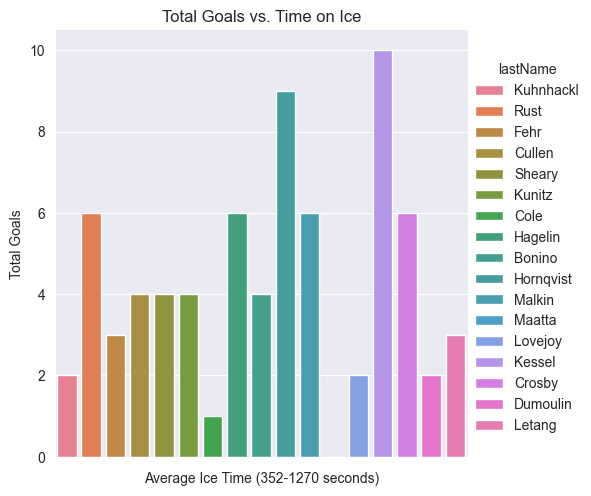

In [359]:
fig = sns.catplot(data= players_2016_sums_df, x='timeOnIce',y='goals',hue='lastName',kind='bar')
fig.set_axis_labels('Average Ice Time (352-1270 seconds)', 'Total Goals')
fig.set(xticklabels=[])
plt.title('Total Goals vs. Time on Ice')


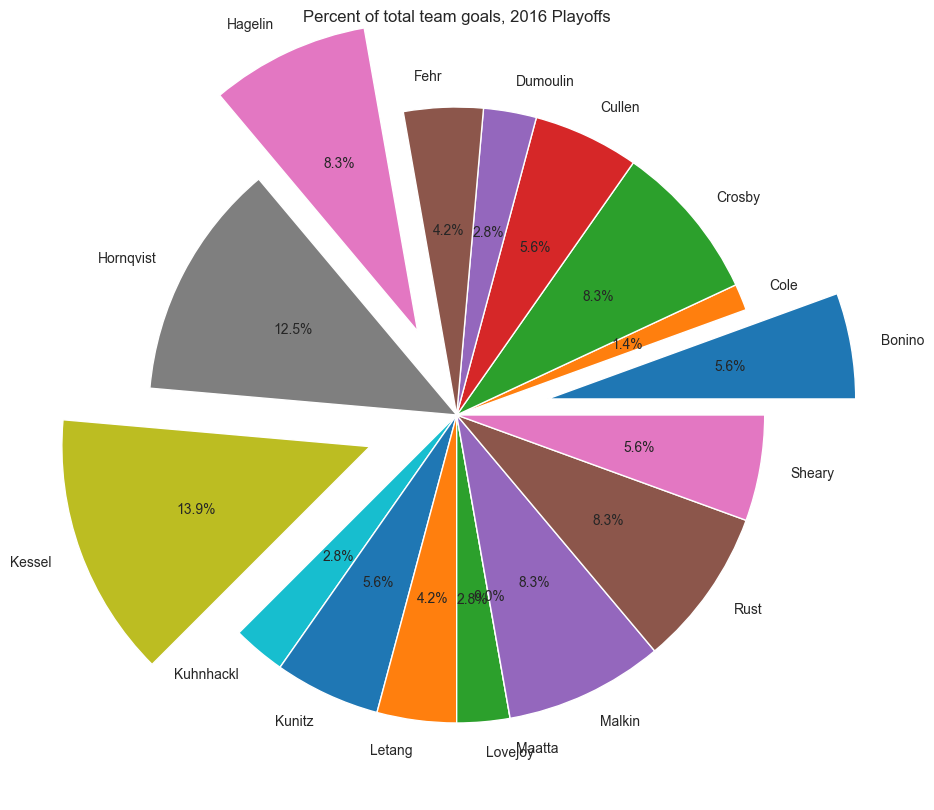

In [419]:
labels = players_2016_sums_df['lastName']
explode = [0.3,0,0,0,0,0,0.3,0,0.3,0,0,0,0,0,0,0,0]
sizes = players_2016_sums_df['goals']

plt.figure(0,figsize = (10,10))
plt.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%')
plt.title('Percent of total team goals, 2016 Playoffs')
plt.show()

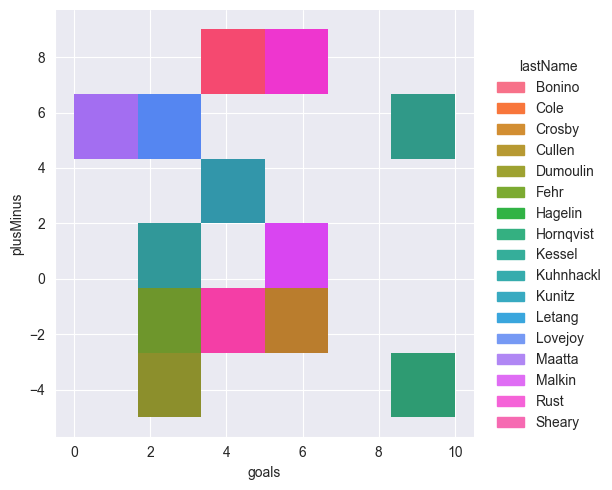

In [420]:
ax = sns.displot(data=players_2016_sums_df, y='plusMinus',x='goals', hue='lastName')
plt.show()

<Axes: xlabel='plusMinus', ylabel='Density'>

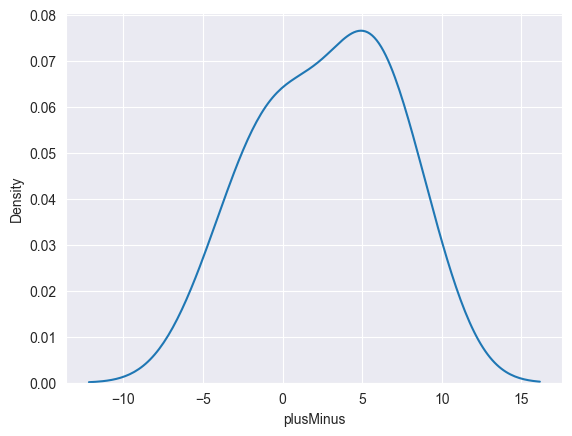

In [380]:
sns.kdeplot(data=players_2016_sums_df,x='plusMinus')